# Training Notebook for Transformer with Classifier Free Guidance
To be run using on the Google Colab servers

### Global setup

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import strftime

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Connect to Github repository and import code

In [2]:
# RUN THIS ONCE AT THE START OF THE SESSION
# clone github repository
!rm -rf /content/VQ-VAE-Tranformer-Image-Gen
!git clone --single-branch --branch modern https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen.git

# add repo to sys path to allow imports
import sys
sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

Cloning into 'VQ-VAE-Tranformer-Image-Gen'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 385 (delta 68), reused 72 (delta 63), pack-reused 286 (from 2)
Receiving objects: 100% (385/385), 184.83 MiB | 16.40 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [3]:
# RUN THIS AT THE START AS WELL AS EVERY TIME THE REPO IS UPDATED
# pull changes from github
%cd /content/VQ-VAE-Tranformer-Image-Gen
!git pull origin modern

# refrsh the imports
from importlib import reload
import TF.model
reload(TF.model)
import TF.model_cfg
reload(TF.model_cfg)
import VQ.model_ivo
reload(VQ.model_ivo)

from VQ.model_ivo import Encoder, Decoder, Quantizer, VQ_VAE, LATENT_W, LATENT_H, NUM_EMBEDDINGS
from TF.model_cfg import CFGTransformerPrior, VOCAB_SIZE, SEQ_LEN, BOS_ID

assert VOCAB_SIZE == NUM_EMBEDDINGS
assert SEQ_LEN == LATENT_H * LATENT_W

/content/VQ-VAE-Tranformer-Image-Gen
From https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen
 * branch            modern     -> FETCH_HEAD
Already up to date.


### Load pretrained Decoder and CelebA embeddings

Loading dataset...
Loading VQ-VAE model...


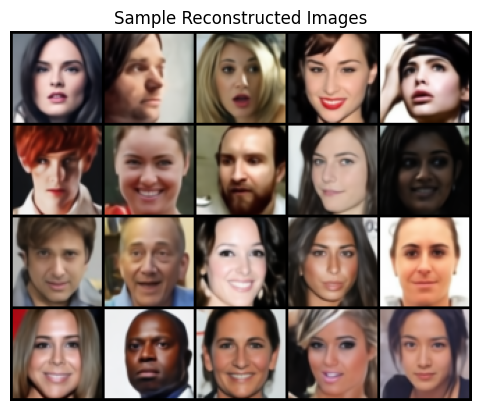

In [4]:
INDICES_PATH = '/content/drive/MyDrive/vq_models/celeba_indices_uint16_ivo.pt'
ATTRS_PATH = '/content/drive/MyDrive/vq_models/celeba_attrs_uint16_ivo.pt'
CHECKPOINT_PATH = '/content/drive/MyDrive/vq_models/checkpoint_ivo_new.pt'

# load CelebA embeddings dataset
print('Loading dataset...')
celeba_embeddings = torch.utils.data.TensorDataset(torch.load(INDICES_PATH), torch.load(ATTRS_PATH))

# load VQ-VAE model parameters
print('Loading VQ-VAE model...')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(use_EMA=True)
vq_vae = VQ_VAE(encoder, decoder, quantizer, use_EMA=True).to(device)
vq_vae.eval()

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
vq_vae.load_state_dict(checkpoint['model_state'])

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba_embeddings[i][0] for i in range(grid_x * grid_y)]).long().to(device)
images = vq_vae.reconstruct_from_indices(samples.view(-1, LATENT_W, LATENT_H))
img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

plt.title(f'Sample Reconstructed Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Initialize Model and dataloader

In [5]:
BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = torch.utils.data.DataLoader(celeba_embeddings, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
model = CFGTransformerPrior().to(device)

### Train model

Checkpoint loaded. Resuming from training step 19840.
15:01:03 Begin Training
Training complete.


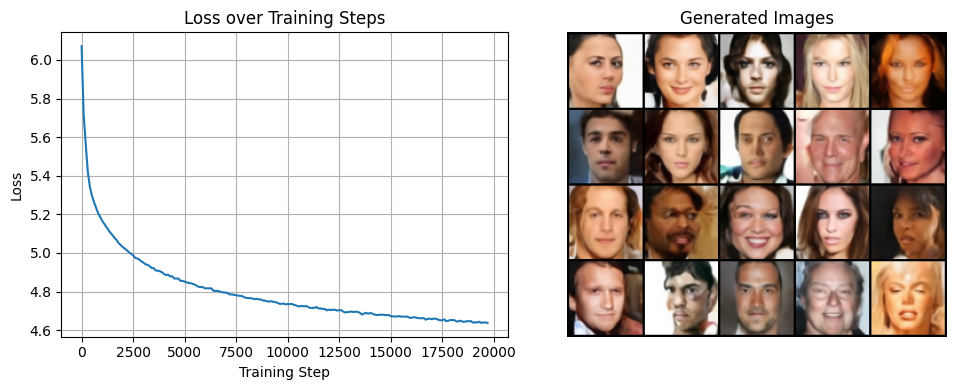

In [11]:
# training hyperparameters
EPOCHS = 0
LEARNING_RATE = 8e-4
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
SAVE_PATH = '/content/drive/MyDrive/tf_models/tf16_cfg' # THE SUFFIX '_{training_step}.pt' will be appended

# model hyperparameters
P_MASK = 0.15

# optionally, resume training from a checkpoint
CONTINUE_FROM_CHECKPOINT = True #  # str | None
CHECKPOINT_PATH = '/content/drive/MyDrive/tf_models/tf16_cfg_19840.pt'

# optmizer and training state vars
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_state = {
    'losses': [],
    'logging_steps': [],
    'running_loss': 0.0,
    'steps': 0
}

# load from checkpoint
if CONTINUE_FROM_CHECKPOINT:
    train_state = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(train_state['model_state'])
    optimizer.load_state_dict(train_state['optmiizer_state'])
    print(f'Checkpoint loaded. Resuming from training step {train_state['steps']}.')

# attributes for sampling reconstructions
_, sample_attrs = next(iter(dataloader))
sample_attrs = sample_attrs.to(device).long()

# training loop
print(f'{strftime('%H:%M:%S')} Begin Training')
end_step = train_state['steps'] + len(dataloader) * EPOCHS
model.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        targets, attrs = batch
        targets = targets.to(device).long()
        attrs = attrs.to(device).long()

        inputs = torch.empty_like(targets)
        inputs[:, 0] = BOS_ID
        inputs[:, 1:] = targets[:, :-1]

        # mask attributes at random
        mask_attr = torch.rand(attrs.shape[0], device=attrs.device) < P_MASK
        attrs[mask_attr] = 2

        logits = model(inputs, attrs)
        loss = nn.functional.cross_entropy(
            logits.view(-1, VOCAB_SIZE),
            targets.view(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_state['steps'] += 1
        train_state['running_loss'] += loss.item()

        # logging step
        if train_state['steps'] % LOG_INTERVAL == 0:
            avg_loss = train_state['running_loss'] / LOG_INTERVAL
            train_state['running_loss'] = 0.0
            train_state['losses'].append(avg_loss)
            print(f'{strftime('%H:%M:%S')} TRAINING Step [{train_state['steps']}/{end_step}]; Loss: {avg_loss:.6f}')

        # saving step
        if train_state['steps'] % SAVE_INTERVAL == 0 or (epoch == EPOCHS - 1 and batch_idx == len(dataloader) - 1):
            train_state['model_state'] = model.state_dict()
            train_state['optmiizer_state'] = optimizer.state_dict()
            model_save_path = f'{SAVE_PATH}_{train_state['steps']}.pt'
            torch.save(train_state, model_save_path)
            print(f'{strftime('%H:%M:%S')} Checkpoint saved at step {train_state['steps']} to {model_save_path}')

            # visualize unconditional reconstructions
            grid_x = 5
            grid_y = 2

            model.eval()
            samples = model.generate(grid_x * grid_y, sample_attrs[:grid_x * grid_y])
            model.train()

            images = vq_vae.reconstruct_from_indices(samples.view(-1, LATENT_W, LATENT_H))
            img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

            plt.title(f'Generated Images at step {train_state['steps']}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            plt.show()

print(f'Training complete.')

train_state['logging_steps'] = [i * 100 for i in range(198)]
torch.save(train_state, CHECKPOINT_PATH)

# Prepare reconstructions
grid_x = 5
grid_y = 4

model.eval()
samples = model.generate(grid_x * grid_y, sample_attrs[:grid_x * grid_y])

images = vq_vae.reconstruct_from_indices(samples.view(-1, LATENT_W, LATENT_H))
img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curves
axes[0].plot(train_state['logging_steps'], train_state['losses'])

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Training Steps')
axes[0].grid(True)

# Reconstructions
axes[1].imshow(img.permute(1, 2, 0).cpu())
axes[1].set_title('Generated Images')
axes[1].axis('off')

plt.tight_layout()
plt.show()